In [35]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [13]:
images_path = '/Users/joanna/datasci_281/final_project/HAM10000_images_preprocessed'
segmentation_path = '/Users/joanna/datasci_281/final_project/HAM10000_segmentations_lesion_tschandl'
metadata = pd.read_csv('HAM10000_metadata.csv')

# get paths for image and segmentation files
img_files = sorted(glob.glob('/'.join([images_path, '*.jpg'])))
segmentation_files = sorted(glob.glob('/'.join([segmentation_path, '*.png'])))
# get the image ID 
img_files_df = pd.DataFrame({'img_file_path': img_files})
img_files_df['image_id'] = img_files_df['img_file_path'].apply(lambda x: x.split('/')[-1].replace('.jpg', ''))
# get the segmentation ID
segmentation_files_df = pd.DataFrame({'segmentation_file_path': segmentation_files})
segmentation_files_df['image_id'] = segmentation_files_df['segmentation_file_path'].apply(lambda x: x.split('/')[-1].replace('_segmentation.png', ''))

# merge the dataframes to make one metadata file
metadata = pd.merge(metadata, img_files_df, left_on= 'image_id', right_on = 'image_id')
metadata = pd.merge(metadata, segmentation_files_df, left_on = 'image_id', right_on = 'image_id')

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_file_path,segmentation_file_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/Users/joanna/datasci_281/final_project/HAM100...,/Users/joanna/datasci_281/final_project/HAM100...


In [14]:
model = ResNet50(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224,224,3),
                 pooling = 'max')

In [21]:
def extract_embeddings(img_path):
    img = image.load_img(img_path, target_size = (224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis = 0)
    preprocessed_img = preprocess_input(img_array_expanded)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    return flattened_features

In [22]:
%%capture 

feature_df = pd.DataFrame()
img_info = metadata[['image_id','img_file_path', 'segmentation_file_path']]
for i in range(len(metadata)):
    feature = pd.DataFrame({'image_id': [img_info['image_id'].iloc[i]],
                           'resnet': [extract_embeddings(img_info['img_file_path'].iloc[i])]})
    feature_df = pd.concat([feature_df, feature], ignore_index= True)

In [26]:
resnet = feature_df['resnet'].tolist()
resnet = np.array(resnet)

pca = PCA(n_components = 2)
value_features = pca.fit_transform(resnet)

In [28]:
feature_df = pd.DataFrame({'image_id': metadata['image_id'],
                           'resnet_feature_1': value_features[:,0],
                           'resnet_feature_2': value_features[:,1]})

In [30]:
feature_df.to_csv('resnet50.csv', index = False)

In [33]:
feature_df = pd.merge(feature_df, metadata[['image_id', 'dx']])

In [40]:
feature_df

,image_id,resnet_feature_1,resnet_feature_2,dx
0,ISIC_0027419,-43.716255,26.776880,bkl
1,ISIC_0025030,8.151252,86.473831,bkl
2,ISIC_0026769,-28.168400,18.195919,bkl
3,ISIC_0025661,4.097778,45.024479,bkl
4,ISIC_0031633,39.101196,6.386570,bkl
...,...,...,...,...
10010,ISIC_0033084,-24.616447,-14.607622,akiec
10011,ISIC_0033550,53.353256,58.222435,akiec
10012,ISIC_0033536,4.614511,20.042778,akiec
10013,ISIC_0032854,-58.521999,24.641087,akiec


In [34]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(resnet)

In [41]:
feature_df = pd.DataFrame({'image_id': metadata['image_id'],
                           'resnet_feature_1': embeddings_2d[:,0],
                           'resnet_feature_2': embeddings_2d[:,1]})

In [42]:
feature_df.to_csv('resnet50_tsne.csv', index = False)

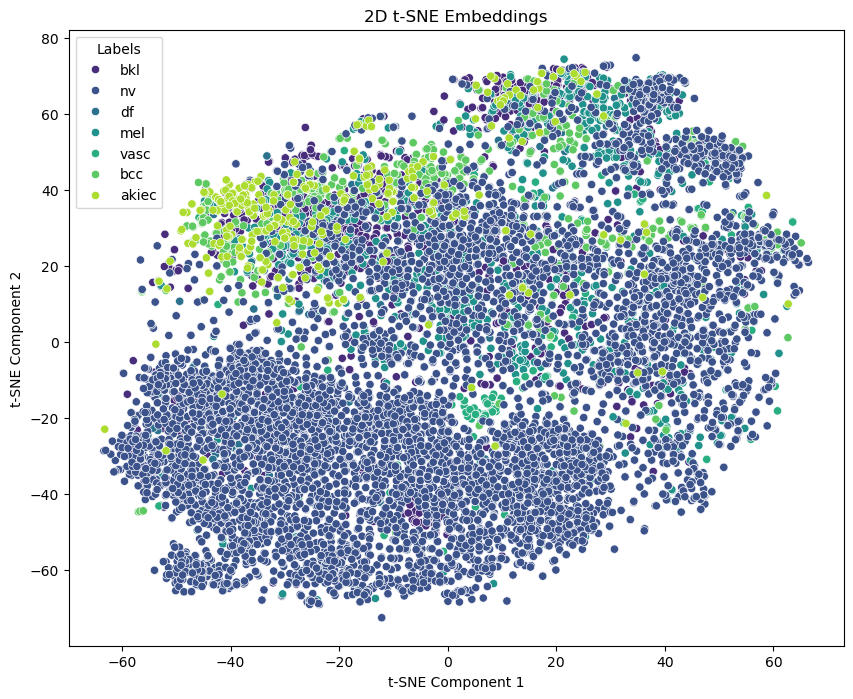

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=feature_df['dx'], palette="viridis")
plt.title('2D t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Labels')
plt.show()